This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [176]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.special import gamma
import scipy.optimize as optimization
import os
from importlib import reload

# Local imports
import sys
sys.path.append('../')
import stlstuff as sls
import imagestuff as ims
#import facetbrightnessstuff9 as fbs
import f90nml
import gradstuff as gds
import statstuff as sts
import fourierstuff as fs
import retrievestuff as rs

In [177]:
%matplotlib notebook

In [178]:
def create_surface1(heightamp):
    # A surface retrieved from observations; arg is used to indicate the segment desired
    flattenedfile = np.load('../crystals/2019-08-02/case1.1/Segments1_compr_flat_filt.npz')
    print('Getting', flattenedfile)
    isegment = 11
    stlfilename = 'Segments1_compr_flat_filt_'+str(isegment)+'_vx5_remade.stl'; print(stlfilename)
    xgridtot = flattenedfile['xgridtot']
    ygridtot = flattenedfile['ygridtot']
    zgridtot = flattenedfile['zgridtot']
    Truesolution = zgridtot[isegment]
    surf_xgridtot = xgridtot[isegment]; dx = surf_xgridtot[0,1]-surf_xgridtot[0,0]; print('dx', dx)
    surf_ygridtot = ygridtot[isegment]; dy = surf_ygridtot[1,0]-surf_ygridtot[0,0]; print('dy', dy)
    Trueny, Truenx = np.shape(Truesolution); print(Truenx, Trueny)
    Truesolution *= 5.263*heightamp # Normalizes it so the std is heightamp
    return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution, stlfilename)

def create_surface2(heightamp):
    # A surface retrieved from observations; arg is used to indicate the segment desired
    flattenedfile = np.load('../crystals/2019-08-02/case1.1/Segments2_compr_flat_filt.npz')
    print('Getting', flattenedfile)
    isegment = 0
    stlfilename = 'Segments2_compr_flat_filt_'+str(isegment)+'_vx5_remade.stl'; print(stlfilename)
    xgridtot = flattenedfile['xgridtot']
    ygridtot = flattenedfile['ygridtot']
    zgridtot = flattenedfile['zgridtot']
    Truesolution = zgridtot[isegment]
    surf_xgridtot = xgridtot[isegment]; dx = surf_xgridtot[0,1]-surf_xgridtot[0,0]; print('dx', dx)
    surf_ygridtot = ygridtot[isegment]; dy = surf_ygridtot[1,0]-surf_ygridtot[0,0]; print('dy', dy)
    Trueny, Truenx = np.shape(Truesolution); print(Truenx, Trueny)
    Truesolution *= 2.948*heightamp # Normalizes it so the std is heightamp
    return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution, stlfilename)

def create_surface3(heightamp):
    # A surface retrieved from observations; arg is used to indicate the segment desired
    flattenedfile = np.load('../crystals/2019-07-02/case2.0 (calibration)/Segments3_compr_flat_filt.npz')
    print('Getting', flattenedfile)
    isegment = 0
    stlfilename = 'Segments1_compr_flat_filt_'+str(isegment)+'_vx5_remade.stl'; print(stlfilename)
    xgridtot = flattenedfile['xgridtot']
    ygridtot = flattenedfile['ygridtot']
    zgridtot = flattenedfile['zgridtot']
    Truesolution = zgridtot[isegment]
    surf_xgridtot = xgridtot[isegment]; dx = surf_xgridtot[0,1]-surf_xgridtot[0,0]; print('dx', dx)
    surf_ygridtot = ygridtot[isegment]; dy = surf_ygridtot[1,0]-surf_ygridtot[0,0]; print('dy', dy)
    Trueny, Truenx = np.shape(Truesolution); print(Truenx, Trueny)
    Truesolution *= 10*heightamp # Normalizes it so the std is heightamp
    return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution, stlfilename)



In [179]:
# Display parameters
azim=-120
elev=40

In [180]:
# Define the variance in the observations (BS units^2)
heightamp = .11
noiseamp = 5**2
noisestd = noiseamp**.5
print('Std deviation in observed (Se^.5) is', noisestd)
realnoise = 1.5
print('Real noise will be', realnoise)

# Define the shrink criterion
shrinkconfidence = .5
minimumdim = 10

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0
print('Std deviation in a priori (Sa^.5) is', apriorivar0**.5)

Std deviation in observed (Se^.5) is 5.0
Real noise will be 1.5
Std deviation in a priori (Sa^.5) is 15.0


In [181]:
# Read and unpack the calibration data
Calibration=f90nml.read('Calibration.nml') #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

In [182]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [183]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes

In [184]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [185]:
# Make the surface
surfacedata = create_surface3(heightamp)
Truenx = surfacedata[0]
Trueny = surfacedata[1]
dx = surfacedata[2]
dy = surfacedata[3]
surf_xgridtot = surfacedata[4]
surf_ygridtot = surfacedata[5]
Truesolution = surfacedata[6]; 

# A little reporting
print('std dev of height', np.std(Truesolution))

# Extract axes
surf_ytot = surf_ygridtot[:,0]; #print(surf_ytot)
surf_xtot = surf_xgridtot[0,:]; #print(surf_xtot)

Getting <numpy.lib.npyio.NpzFile object at 0x1a2b85cd68>
Segments1_compr_flat_filt_0_vx5_remade.stl
dx 0.7632211
dy 0.7632211
33 69
std dev of height 0.12679194269841715


<IPython.core.display.Javascript object>


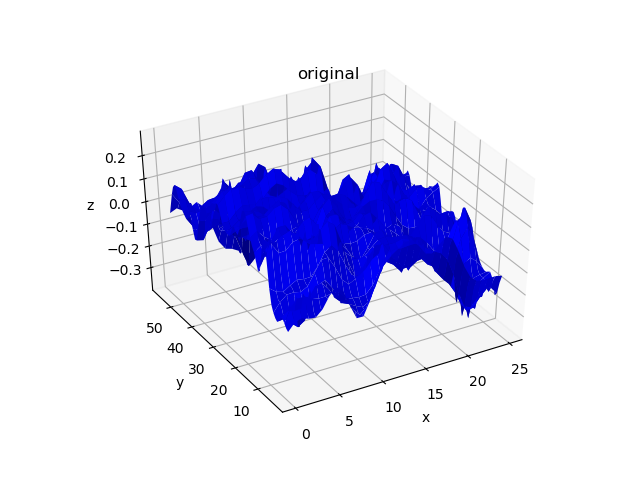

Text(0.5,0.92,'original')

In [186]:
# Display this surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, Truesolution, color='b')
#ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=azim,elev=elev)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
ax.set_title('original')

In [187]:
# Create "observed" backscatter intensities from the forward model

# Get gradients of the true solution
surf_dzgrid_dy_retrieved = np.diff(Truesolution,axis=0)/dy
surf_dzgrid_dx_retrieved = -np.diff(Truesolution,axis=1)/dx

# Generate "observed" backscatter intensities
bigKx = np.matrix(np.empty((4,0)), copy=False)
bigKy = np.matrix(np.empty((4,0)), copy=False)
bigc_last = np.matrix(np.empty((4,0)), copy=False)
for iy in range(Trueny-1):
    for ix in range(Truenx-1):
        dzdx = surf_dzgrid_dx_retrieved[iy,ix]; #print('dzdx =', dzdx)
        dzdy = surf_dzgrid_dy_retrieved[iy,ix]; #print('dzdy =', dzdy)
        nxy_last = np.vstack((dzdx,dzdy))
        K_i, c_last = rs.getK(nxy_last,
        Arule, Brule, Crule, Drule,
        KAxrule, KAyrule,
        KBxrule, KByrule,
        KCxrule, KCyrule,
        KDxrule, KDyrule)
        bigKx = np.hstack((bigKx,K_i[:,0]))
        bigKy = np.hstack((bigKy,K_i[:,1]))
        bigc_last = np.hstack((bigc_last,c_last))
cA_orig = np.reshape(bigc_last[0],(Trueny-1,Truenx-1))
cB_orig = np.reshape(bigc_last[1],(Trueny-1,Truenx-1))
cC_orig = np.reshape(bigc_last[2],(Trueny-1,Truenx-1))
cD_orig = np.reshape(bigc_last[3],(Trueny-1,Truenx-1))
ny,nx = cA_orig.shape; 
print(ny,nx)

68 32


In [188]:
# Add some noise to the observed signals
cA = cA_orig + np.random.randn(ny,nx)*realnoise
cB = cB_orig + np.random.randn(ny,nx)*realnoise
cC = cC_orig + np.random.randn(ny,nx)*realnoise
cD = cD_orig + np.random.randn(ny,nx)*realnoise
print(np.std(cA))
print(np.max(cA))
print(np.min(cA))

1.608594813461376
135.0416901399966
122.96773400565942


<IPython.core.display.Javascript object>


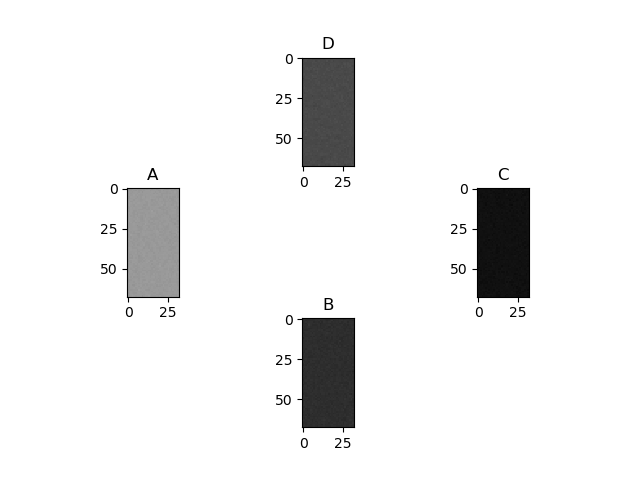

Text(0.5,1,'D')

In [189]:
plt.figure()
vmin = 0; vmax = 255
plt.subplot(334); plt.imshow(np.asarray(cA), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('A')
plt.subplot(338); plt.imshow(np.asarray(cB), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('B')
plt.subplot(336); plt.imshow(np.asarray(cC), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('C')
plt.subplot(332); plt.imshow(np.asarray(cD), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('D')

In [190]:
# Save original size information
xarr = surf_xtot[0:-1]; nx = np.size(xarr); print('nx =', nx)
yarr = surf_ytot[0:-1]; ny = np.size(yarr); print('ny =', ny)
xarrnew = surf_xtot[1:-1]; nx = np.size(xarr); print('nx =', nx)
yarrnew = surf_ytot[1:-1]; ny = np.size(yarr); print('ny =', ny)
xarr_orig = copy.copy(xarr); yarr_orig = copy.copy(yarr); ny_orig = copy.copy(ny); nx_orig = copy.copy(nx)

# Packaging
cseg = [cA,cB,cC,cD]; print('Shape of observations:', np.shape(cseg[0]))

# Trying out the interpolation idea
xarr,yarr,cseg = rs.scaledown(xarr,yarr,cseg,shrinkconfidence,minimumdim)

nx = 32
ny = 68
nx = 32
ny = 68
Shape of observations: (68, 32)
0 1 4.147039413156344
0 2 -13.23165565009723
0 3 -1.901878535307707
1 2 -1.6746746463529614
1 3 -6.327988459359128
2 3 3.170856040636533
Correlation score = 15.773207988340454
Benchmark random signals = 5.317933040410493
ishrink =  0
Stopping shrinking b/c infoscore is = 15.773207988340454


In [191]:
# Repackage
cA = cseg[0]
cB = cseg[1]
cC = cseg[2]
cD = cseg[3]
ny,nx = cA.shape; print(ny,nx)

# Number of observations
nobs = (nx-1)*(ny-1)*4; print('nobs =', nobs) # Number of observations
nXobs = np.size(cA); print('nXobs =', nXobs)

# Number of desired points (heights)
nzpts = ny*nx-1; print('nheights =', nzpts)

68 32
nobs = 8308
nXobs = 2176
nheights = 2175


In [192]:
# Generic retrieval parameters
maxiter = 6
tolerance = 10*nzpts/1000; print('tolerance =', tolerance)

tolerance = 21.75


In [193]:
# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

In [194]:
# Retrieve 

# Construct gradients
Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
Ny = Ny_unscaled/dy
Nx = -Nx_unscaled/dx #fixing x inversion

# Extract the a priori variance
vartemp = apriorivar[0:ny,0:nx]
vartemp_long = np.reshape(vartemp,nzpts+1,0)
Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)

# Construct the variance in observation + model
Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

# Do the retrieval
# print('')
# surf_xgrid, surf_ygrid, solution_interpolated = rs.retrievesegmentwithshrinking(\
# xarrnew,yarrnew,shrinkconfidence,minimumdim,\
# nx-1,ny-1,cA,cB,cC,cD,\
# apriorivar,noiseamp,maxiter,tolerance,\
# Nx,Ny,\
# Arule, Brule, Crule, Drule,\
# KAxrule, KAyrule, \
# KBxrule, KByrule, \
# KCxrule, KCyrule, \
# KDxrule, KDyrule)

print('')
# Create a blank slate
solution = np.zeros(cA.shape)
# Extract the starting z
settemp = copy.copy(solution)
settemp_long = np.reshape(settemp,nzpts+1,0)
settemp_longminus1 = settemp_long[:-1]
z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
z_start = z_start*0.0; #print "aprioriset", shape(z_start)
z_retrieved = rs.retrievesegment(\
0,0,nx-1,ny-1,cA,cB,cC,cD,\
Sa,Se,z_start,maxiter,tolerance,\
Nx,Ny,\
Arule, Brule, Crule, Drule,\
KAxrule, KAyrule, \
KBxrule, KByrule, \
KCxrule, KCyrule, \
KDxrule, KDyrule)
solution = copy.copy(z_retrieved)
interpz = interp2d(xarr, yarr, solution, kind='linear') # Expands back out to the original size
solution_interpolated = interpz(xarr_orig,yarr_orig)
surf_xgrid, surf_ygrid = np.meshgrid(xarr_orig,yarr_orig) # Makes grids to match the solution


Observed intensities (detector B):
mean, max, min = 38.312325302896575 44.018222612529016 32.98114122757158
<diff>, std(diff), di2 = -0.016040546340695905 1.5619370208798036 263.66683438590326
<diff>, std(diff), di2 = -0.010610782608670604 1.2832039020859551 0.12102839019961671


In [195]:
# Re-level to match the true solution as closely as possible
shift = np.mean(Truesolution)-np.mean(solution_interpolated); #print(shift)
solution_interpolated += shift

In [196]:
# Fourier transform & filter

# Set the low-pass threshold
kmax = 2.0

# Do the filtering
solution_filtered = fs.filterseg(kmax,surf_xgrid,surf_ygrid,solution_interpolated)[0]; 

# Get rid of the edges
surf_xgrid_truncated = surf_xgrid[1:-2,1:-2]; print(np.shape(surf_xgrid_truncated))
surf_ygrid_truncated = surf_ygrid[1:-2,1:-2]; print(np.shape(surf_ygrid_truncated))
Retrsolution = solution_filtered[1:-2,1:-2]; print(np.shape(Retrsolution))

(65, 29)
(65, 29)
(65, 29)


<IPython.core.display.Javascript object>


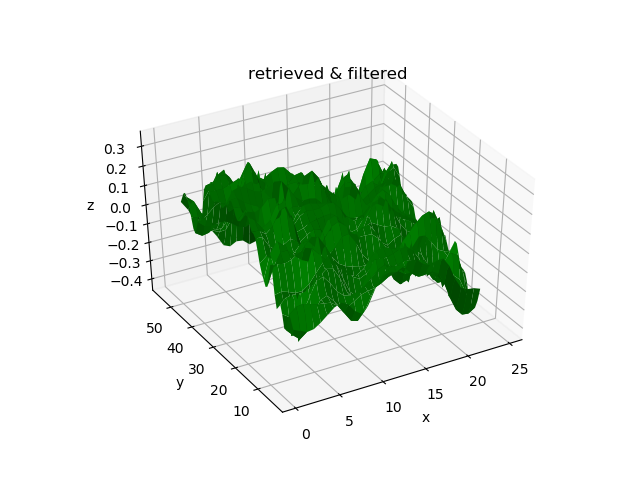

Shape of the filtered solution: (68, 32)
std dev of height = 0.13736428870617734
lambda cutting off at 3.141592653589793 um


In [197]:
# Graphing the filtered surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgrid_truncated, surf_ygrid_truncated, Retrsolution, color='g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('retrieved & filtered')
ax.view_init(azim=azim,elev=elev)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
#ax.set_zlim(zlim)

# Reporting
print('Shape of the filtered solution:', np.shape(solution_filtered))
variability = np.std(solution_filtered); print('std dev of height =', variability)
print('lambda cutting off at', np.pi*2/kmax, 'um')

<IPython.core.display.Javascript object>


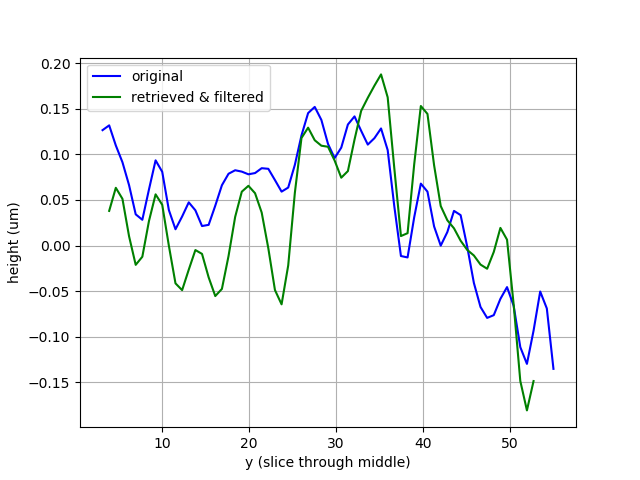

In [198]:
# Show a slice of the reconstructed surface
plt.figure()
midpt = int(nx/2)
plt.plot(surf_ytot,Truesolution[:,midpt], 'b-', label='original')
plt.plot(surf_ygrid_truncated[:,0],np.array(Retrsolution[:,midpt-1]), 'g-', label='retrieved & filtered')
plt.xlabel('y (slice through middle)')
plt.ylabel('height (um)')
plt.grid(True)
plt.legend()

In [199]:
RetrmeanZ2 = rs.getmeanz2(Retrsolution,dx,dy); print(RetrmeanZ2); RetrZ2maxforhist = RetrmeanZ2*3
TruemeanZ2 = rs.getmeanz2(Truesolution,dx,dy); print(TruemeanZ2); TrueZ2maxforhist = TruemeanZ2*3

0.005461139435076736
0.0043334902085088


Max number of bins specified is 8
Using levels = 3 for uncertainty analysis


<IPython.core.display.Javascript object>


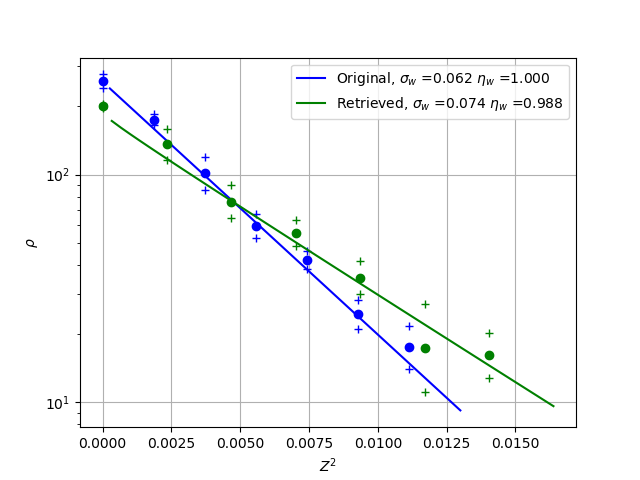


For the original ...
<Z2>= 0.06582925040214874
Sturges rule says maxbins = 12
Using nbins =  8
Original =  2176
4 0 544 [198 142  71  39  31  21  12]
4 1 544 [211 127  64  49  35  17  11]
4 2 544 [186 132  87  49  29  20  13]
4 3 544 [188 130  86  44  33  16  17]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
True meanZ2 =  0.0043334902085088
True statsigma =  0.06582925040214874
integral =  0.0014799924910359086
Based on bins: sigmaW, etaW of original =  0.06255193256393325 1.0002415576722696

For the retrieved ...
<Z2>= 0.07389952256325298
Sturges rule says maxbins = 11
Using nbins =  8
For the retrieved ...
Original =  1792
4 0 448 [160 126  53  49  24   6  10]
4 1 448 [158  92  73  46  30  18  14]
4 2 448 [162 100  60  43  25  20  11]
4 3 448 [155 112  55  37  33  11  16]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
Retr meanZ2 =  0.005461139435076736
Retr statsigma =  0.07389952256325298
integral =  0.0018679824452948934
Based on bins: sigmaW, etaW of retrieved/filtered =  0.0746

../statstuff.py:502: RuntimeWarning: invalid value encountered in power
  term2 = (Z2/sigma2W)**(etaW-1)
../statstuff.py:503: RuntimeWarning: invalid value encountered in power
  term3 = np.exp(-(Z2/sigma2W)**etaW)


In [200]:
# Get the probability distributions in Z2

# Parameters
Z2minforhist = 0.0
Z2offset = 1e-7
nbins_max = 8; print('Max number of bins specified is', nbins_max)
levels = 3; print('Using levels =', levels, 'for uncertainty analysis')
meanZ2threshold = .005
x0 = np.array([.1,.9])
plt.figure()

# This is for the true solution
print('')
print('For the original ...')
print('<Z2>=',np.sqrt(TruemeanZ2))
if (np.sqrt(TruemeanZ2) > meanZ2threshold):

    # Get the probability for the original
    Ntot = np.size(Truesolution)
    nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
    nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
    TrueZ2bins = np.linspace(Z2minforhist,TrueZ2maxforhist,nbins); #print(Z2bins)
    TrueZ2theory = np.linspace(Z2minforhist,TrueZ2maxforhist,50); TrueZ2theory=TrueZ2theory[1:] # This is for Weibull plots
    
    Truecounts, bins, TruemeanZ2, TrueZ2flat, Trueerror = rs.getrhoofz2(Truesolution,dx,dy,Z2bins=TrueZ2bins,levels=levels)
    print('True meanZ2 = ', TruemeanZ2)
    print('True statsigma = ', np.sqrt(TruemeanZ2))
    Trueintegral_rho = np.trapz(Truecounts, bins); print('integral = ', Trueintegral_rho)
    Truecounts = Truecounts/Trueintegral_rho
    Trueerror = Trueerror/Trueintegral_rho
    Truecountsplus = Truecounts+Trueerror; 
    Truecountsminus = Truecounts**2/Truecountsplus
    
    Trueerrors = np.log(Truecountsplus/Truecounts); #print(errors)
    Truesol, Truesolerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(Truecounts),x0,sigma=Trueerrors)
    TrueetaW = Truesol[1]
    Truesigma2W = Truesol[0]
    TruesigmaW = np.sqrt(Truesigma2W)
    print('Based on bins: sigmaW, etaW of original = ', TruesigmaW, TrueetaW)

    # Graph the data
    plt.semilogy(bins, Truecounts, 'ob')

    # Graph the best-fit probability
    myWeibull = sts.Weibull(TrueZ2theory,Truesigma2W,TrueetaW)
    plt.semilogy(TrueZ2theory, myWeibull, 'b',label = 'Original, $\sigma_w$ =' + str(TruesigmaW)[0:5] + ' $\eta_w$ =' + str(TrueetaW)[0:5])

    # Add the error bars    
    plt.semilogy(bins, Truecountsplus, '+b')
    plt.semilogy(bins, Truecountsminus,'+b')

else:
    print('True is too flat to analyze')
    
# This is for the retrieved solution
print('')
print('For the retrieved ...')
print('<Z2>=',np.sqrt(RetrmeanZ2))
if (np.sqrt(RetrmeanZ2) > meanZ2threshold):

    # Get the probability for the original
    Ntot = np.size(Retrsolution)
    nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
    nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
    RetrZ2bins = np.linspace(Z2minforhist,RetrZ2maxforhist,nbins); #print(Z2bins)
    RetrZ2theory = np.linspace(Z2minforhist,RetrZ2maxforhist,50); RetrZ2theory=RetrZ2theory[1:] # This is for Weibull plots
    
    # Get the probability for the retrieved
    print('For the retrieved ...')
    Retrcounts, bins, RetrmeanZ2, RetrZ2flat, Retrerror = rs.getrhoofz2(Retrsolution,dx,dy,Z2bins=RetrZ2bins,levels=levels)
    print('Retr meanZ2 = ', RetrmeanZ2)
    print('Retr statsigma = ', np.sqrt(RetrmeanZ2))
    Retrintegral_rho = np.trapz(Retrcounts, bins); print('integral = ', Retrintegral_rho)
    Retrcounts = Retrcounts/Retrintegral_rho
    Retrerror = Retrerror/Retrintegral_rho
    Retrcountsplus = Retrcounts+Retrerror; 
    Retrcountsminus = Retrcounts**2/Retrcountsplus
    
    Retrerrors = np.log(Retrcountsplus/Retrcounts); #print(errors)
    Retrsol, Retrsolerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(Retrcounts),x0,sigma=Retrerrors)
    RetretaW = Retrsol[1]
    Retrsigma2W = Retrsol[0]
    RetrsigmaW = np.sqrt(Retrsigma2W)
    print('Based on bins: sigmaW, etaW of retrieved/filtered = ', RetrsigmaW, RetretaW)

    # Graph the data
    plt.semilogy(bins, Retrcounts, 'og')

    # Graph the best-fit probability
    myWeibull = sts.Weibull(RetrZ2theory,Retrsigma2W,RetretaW)
    plt.semilogy(RetrZ2theory, myWeibull, 'g',label = 'Retrieved, $\sigma_w$ =' + str(RetrsigmaW)[0:5] + ' $\eta_w$ =' + str(RetretaW)[0:5])

    # Add the error bars    
    plt.semilogy(bins, Retrcountsplus, '+g')
    plt.semilogy(bins, Retrcountsminus,'+g')

else:
    print('Retrieved is too flat (or observation is too noisy) to analyze')


# Labels, etc
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)
plt.legend()

# Results:

### The following pertains for when the retrieval is run at full resolution

#### When the input structure is flat (relief ~.01 um):  
- If the noise is low (like 1 BSU), the correlation score ranges from 5-10/8 (8 is the benchmark value). The roughness is Gaussian and low, but non-zero (like sigmaW = .03). The std height error is around .04 um, with a retrieved discrepancy of std(diff)=0.8 BSU. Setting the GNBF observation estimate (Se) to a higher value than the noise (like Se^.5 = 3 BSU when noise = 1 BSU) yields similar results.  
- If the noise is high (like 5), the correlation score is around 5/8, and the retrieval produces a surface with significant "phantom" relief, like 0.2 um. The roughness is Gaussian, and unrealistically high (like sigmaW = .2).  The retrieved discrepancy is std(diff) = 4 BSU.   
- If the noise is very high (like 10 BSU), the correlation score remains around 5/8, the roughness is Gaussian, and absurdly high (like sigmaW = 1).  


Conclusions: A *low* correlation score (compared to the random benchmark) generally means a bad retrieval. Also, we need noise on the order of 1 BSU to avoid creating phantom structure large enough to impact sigmaW. 

#### When the input structure is moderately rough (relief ~.1 um) :  
- If the noise is low (like 1 BSU), the correlation score ~50/8, the roughness is Gaussian, and matches the input roughness to within 0.01 (like sigmaW = .105 vs .095). The std height error is around .04 um, with a retrieved discrepancy std(diff) = 0.9 BSU.  
- If the noise is high (like 5 BSU), the correlation score drops back to 4/8, the roughness is Gaussian, and exceeds the input roughness significantly (like sigmaW = .16 vs .095).  

Conclusions: A *high* correlation score means a good retrieval. We still need noise on the order of 1 BSU to avoid creating phantom structure large enough to impact sigmaW.


#### When the input structure is a little rougher (relief ~.2 um) :  
-If the noise is low (like 1 BSU), the information score ~70/8, the roughness is Gaussian, and matches the input roughness to within 0.01 (like sigmaW = .19 vs .18). The std height error is around .04 um, with a retrieved discrepancy std(diff) = 0.9 BSU.  
-If the noise is high (like 5 BSU), the correlation score drops back to around 5/8, the roughness is Gaussian, and exceeds the input roughness significantly (like sigmaW = .22 vs .18).  

Conclusions: A *high* correlation score means a good retrieval. We still need noise on the order of 1 BSU to avoid creating phantom structure large enough to impact sigmaW.


#### When the input structure is very (unrealistically) rough (relief ~1 um) :  
- If the noise is low (like 1 BSU), the correlation score rises to > 100/8, the roughness is Gaussian, and matches the input roughness well (like sigmaW = .82 vs .81). The std height error is around .07 um, with a retrieved discrepancy std(diff)=0.9 BSU.  
- If the noise is high (like 5 BSU), the correlation score falls to ~50/8, the roughness is Gaussian, and exceeds the input roughness somewhat (like sigmaW = .9 vs .8). The retrieved discrepancy is std(diff) = 4 BSU.  

Conclusions: A *high* correlation score means a good retrieval. Even noise on the order of 5 BSU does not significantly impact sigmaW.


### The following pertains for when the retrieval checks for low correlation scores and "shrinks" the input images

#### When the input structure is flat (relief ~.01 um):  
- If the noise is low (like 1 BSU), shrinking by a factor of 4 in both directions (from 28x48 to 7x12 pixels), which has a correlation score of 31/26. Resulting std height variation is ~0.01 um. The roughness is sigmaW=0.006, compared to 0.008 for the original. So this is all great; the retrieval reduced the roughening, only by a tiny amount.  
- If the noise is high (like 5 BSU), shrinking is the same (from 28x48 to 7x12 pixels), correlation score of 45/26. The roughness is sigmaW=0.03, compared to 0.008 for the original. So this is also fine; the retrieval thinks it's rougher, but not by much.   

#### When the input structure is moderately rough (relief ~.1 um) : 
- If the noise is low (like 1 BSU), no shrinking needed since correlation score is 44/7. The roughness is sigmaW=0.09, compared to 0.07 for the original. So this is all great. 
- If the noise is high (like 5 BSU), shrinking by a factor of 4 in both directions (from 28x48 to 7x12 pixels), which has a correlation score of 26/28. The roughness is sigmaW=0.04, compared to 0.07 for the original. So this is fine; the retrieval thinks it's a little smoother than it really is.

#### When the input structure is a little rougher (relief ~.2 um) : 
- If the noise is low (like 1 BSU), no shrinking needed since correlation score is 82/7. The roughness is sigmaW=0.13, compared to 0.17 for the original. So this is fine; the retrieval thinks it's a little smoother than it really is. 
- If the noise is high (like 5 BSU), shrinking from 28x48 to 7x12 pixels, with correlation score of 26/27. The roughness is sigmaW=0.05, compared to 0.17 for the original. So this is fine; the retrieval thinks it's a little smoother than it really is.

#### When the input structure is very (unrealistically) rough (relief ~1 um) :  
- If the noise is low (like 1 BSU), the correlation score rises to > 100/7, so no shrinking. sigmaW = .67 compared to .86 for the original.
- If the noise is high (like 5 BSU), the correlation score falls to ~55/7, still no shrinking. The roughness is sigmaW = .89 compared to .86 for the original. The retrieved discrepancy is std(diff) = 4 BSU.  



In [201]:
# Save an image
#fig.savefig('benchmark.jpg')

# # Save stl files
# vscale = 5
# stlfilename = surfacedata[7]; print(stlfilename)
# #sls.numpy2stl(np.fliplr(sollast_FT_filtered_IFT_real[1:-2,1:-2]), stlfilename, scale=vscale/dx, solid=False)
# sls.numpy2stl(Retrsolution, stlfilename, scale=vscale/dx, solid=False)

In [202]:
# Compressedfilename = 'benchmarkretrieved.npz'
# print("saving", Compressedfilename)
# np.savez_compressed(Compressedfilename, \
#                     surfaceroot='2018', \
#                     imageroot='2018', \
#                     nx1list=[0], \
#                     nx2list=[nx-1], \
#                     ny1list=[0], \
#                     ny2list=[ny-1], \
#                     pA=pA, \
#                     pB=pB, \
#                     pC=pC, \
#                     pD=pD, \
#                     sA=sA, \
#                     sB=sB, \
#                     sC=sC, \
#                     sD=sD, \
#                     nxi=nxi, \
#                     nyi=nyi, \
#                     dnx=dnx, \
#                     dny=dny, \
#                     solution=solution)

In [203]:
# # More attempts to understand how the FT works
# import fourierstuff as fs
# x = np.linspace(0,20,50)
# y = np.linspace(0,20,51)
# xgrid,ygrid = np.meshgrid(x,y)
# lambdax = 5; kx = np.pi*2/lambdax; print(kx)
# lambday = 4; ky = np.pi*2/lambday; print(ky)
# sollast = np.sin(kx*xgrid) + np.sin(ky*ygrid)
# Ny, Nx = np.shape(sollast)

# # FT
# sollast_FTshift,kxshift,kyshift = fs.FT(sollast,x,y)
# kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift);
# sollast_FTshift_square = np.real(sollast_FTshift)**2 +  np.imag(sollast_FTshift)**2 


# # Plotting
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xgrid, ygrid, sollast)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('original')

# plt.figure()
# plt.contour(kxshiftgrid, kyshiftgrid, sollast_FTshift_square)
# plt.xlabel('kx')
# plt.ylabel('ky')
# plt.title('Power spectrum')
# plt.grid(True)


In [204]:
# def create_surface1():
#     # Creates a sloped plane; arg is not used
#     Truenx = 35; Trueny = 36; dx = dy = 0.66
#     Truesolution = np.zeros((Trueny,Truenx))
#     slopey = 0.0
#     slopex = 0.0
#     for ix in range(Truenx):
#         for iy in range(Trueny):
#             Truesolution[iy,ix] += iy*slopey*dy
#     for ix in range(Truenx):
#         for iy in range(Trueny):
#             Truesolution[iy,ix] += ix*slopex*dx
#     #print(np.shape(Truesolution))
#     ymax = dy*(Trueny-1)
#     xmax = dx*(Truenx-1)
#     surf_ytot = np.linspace(0,ymax,Trueny); #print(surf_ytot[1]-surf_ytot[0]); 
#     surf_xtot = np.linspace(0,xmax,Truenx); #print(surf_xtot[1]-surf_xtot[0]); 
#     surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
#     return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution)

# def create_surface2():
#     # Creates a surface based on a bunch of sines and cosines; arg is not used
#     Truenx = 29; Trueny = 49; dx = dy = 0.66
#     height = 0.00005
#     ymax = dy*(Trueny-1)
#     xmax = dx*(Truenx-1)
#     surf_ytot = np.linspace(0,ymax,Trueny); #print(surf_ytot[1]-surf_ytot[0]); 
#     surf_xtot = np.linspace(0,xmax,Truenx); #print(surf_xtot[1]-surf_xtot[0]); 
#     surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
#     lambdax1 = 5; kx1 = np.pi*2/lambdax1
#     lambdax2=  7; kx2 = np.pi*2/lambdax2
#     lambdax3=  10; kx3 = np.pi*2/lambdax3
#     lambday1 = 7; ky1 = np.pi*2/lambday1
#     lambday2 = 8; ky2 = np.pi*2/lambday2  
#     lambday3 = 9; ky3 = np.pi*2/lambday3  
#     term1 = np.cos(kx1*surf_xgridtot) + np.sin(ky1*surf_ygridtot)
#     term2 = np.sin(kx2*surf_xgridtot) + np.cos(ky2*surf_ygridtot)
#     term3 = np.cos(kx3*(surf_xgridtot+surf_xgridtot) + np.sin(ky3*(surf_ygridtot+surf_xgridtot)))
#     Truesolution = (term1*term2+term3)*height
#     return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution)
